In [4]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=[]


# Rissos whale vocalizations
Source:
- https://www.mobysound.org/
- http://localhost:8186/tree/Datasets/mobysound/Rissos-SCORE-annot


In [5]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import librosa

In [6]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams
from avgn_paper.signalprocessing.filtering import butter_bandpass_filter
from avgn_paper.signalprocessing import spectrogramming as sg
import wave

### data locations

In [7]:
DSLOC = Path('/mnt/cube/Datasets/mobysound/Rissos-SCORE-annot/')

In [8]:
DSLOC

PosixPath('/mnt/cube/Datasets/mobysound/Rissos-SCORE-annot')

### load wavs

In [9]:
wavs = list(DSLOC.glob('*.wav'))
len(wavs), wavs[:3]

(1,
 [PosixPath('/mnt/cube/Datasets/mobysound/Rissos-SCORE-annot/Set1-A2-H17-081406-0000-0030-1225-1255loc.wav')])

In [10]:
wav_df = pd.DataFrame(columns = ['stem', 'path', 'rate'])
for wav in wavs:
    with wave.open(wav.as_posix(), 'rb') as f:
        rate = f.getframerate()
    wav_df.loc[len(wav_df)] = [wav.stem, wav, rate]

In [11]:
wav_df

stem  \
0  Set1-A2-H17-081406-0000-0030-1225-1255loc   

                                                path   rate  
0  /mnt/cube/Datasets/mobysound/Rissos-SCORE-anno...  96000

### Load labels

In [18]:
click_types = [
    ['good', '*GoodSingle.txt'],
    ['poor', '*PoorSingle.txt'],
    ['possible', '*Possible.txt']
]

In [19]:
clicks_df = []
for click_type, click_type_glob in click_types:
    good_clicks = list(DSLOC.glob(click_type_glob))
    for click_label_loc in good_clicks:
        good_clicks_df = pd.read_csv(click_label_loc, delimiter='\t')
        good_clicks_df['stem'] = click_label_loc.stem
        good_clicks_df['click_value'] = click_type
        clicks_df.append(good_clicks_df)
clicks_df = pd.concat(clicks_df)
clicks_df.columns = [re.sub(' +', ' ', i) for i in clicks_df.columns]

In [20]:
len(clicks_df)

6195

In [21]:
clicks_df[:3]

% start time   end time     low freq    high freq  Unnamed: 4  \
0       4.26258    4.27124  21328.39072  40132.12268         NaN   
1       4.39858    4.40724  21427.35773  40033.15567         NaN   
2       4.57381    4.58400  21526.32474  41913.52887         NaN   

                                                stem click_value  
0  Set1-A2-H17-081406-0000-0030-1225-1255loc.Good...        good  
1  Set1-A2-H17-081406-0000-0030-1225-1255loc.Good...        good  
2  Set1-A2-H17-081406-0000-0030-1225-1255loc.Good...        good

In [22]:
clicks_df.columns

Index(['% start time', ' end time', ' low freq', ' high freq', 'Unnamed: 4',
       'stem', 'click_value'],
      dtype='object')

In [23]:
clicks_df.click_value.unique()

array(['good', 'poor', 'possible'], dtype=object)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


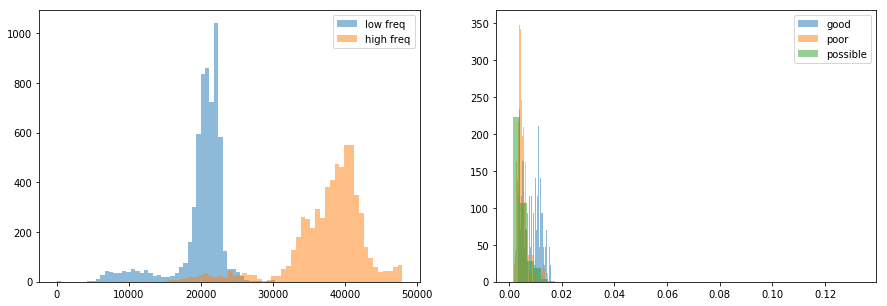

In [24]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
axs[0].hist(clicks_df[" low freq"].values, bins=50, alpha=0.5, label="low freq")
axs[0].hist(clicks_df[" high freq"].values, bins=50, alpha=0.5, label="high freq")

for click_value in clicks_df.click_value.unique():
    axs[1].hist(
        clicks_df[clicks_df.click_value == click_value][" end time"].values
        - clicks_df[clicks_df.click_value == click_value]["% start time"].values,
        bins=50, normed = True, label=click_value, alpha = 0.5
    )

axs[0].legend()
axs[1].legend()

### get example click

In [25]:
click_row = clicks_df.iloc[1]

In [26]:
click_row

% start time                                              4.39858
 end time                                                 4.40724
 low freq                                                 21427.4
 high freq                                                40033.2
Unnamed: 4                                                    NaN
stem            Set1-A2-H17-081406-0000-0030-1225-1255loc.Good...
click_value                                                  good
Name: 1, dtype: object

In [30]:
wav_row

NameError: name 'wav_row' is not defined

In [32]:
click_row.stem

'Set1-A2-H17-081406-0000-0030-1225-1255loc.GoodSingle'

In [33]:
wav_df.stem == '_'.join(click_row.stem.split('.')[:-1])

0    True
Name: stem, dtype: bool

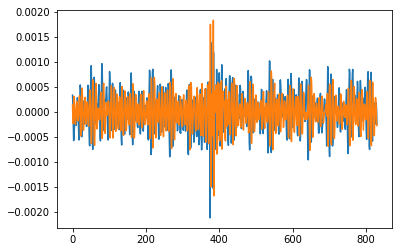

In [34]:
wav_row = wav_df[wav_df.stem == '_'.join(click_row.stem.split('.')[:-1])].iloc[0]
wav_loc = wav_row.path

rate = wav_row.rate
data, rate = librosa.core.load(
    path=wav_loc,
    sr=None,
    offset=click_row["% start time"],
    duration=click_row[" end time"] - click_row["% start time"],
    mono=False
)
data = np.transpose(data)
click = butter_bandpass_filter(data, lowcut = 100, highcut=int(rate/2)-2, fs=rate, order=4)
plt.plot(click)
click = butter_bandpass_filter(click, lowcut = 10000, highcut=int(rate/2)-2, fs=rate, order=4)
plt.plot(click)

In [35]:
rate

96000

In [36]:
win_length_ms = .25
hop_length_ms = .02
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=4800,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-80,
    preemphasis=0.97,
    # mel scaling
    num_mel_bins=128,
    mel_lower_edge_hertz=1000,
    mel_upper_edge_hertz=rate/2,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)

24.0
1.9200000000000002


In [37]:
spectrogram = sg.spectrogram(click, hparams)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


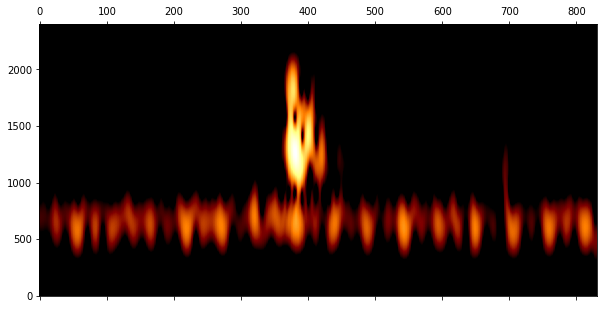

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
ax.matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')

In [39]:
nrow = 3
ncol = 10
zoom_x = 3
zoom_y = 2

good


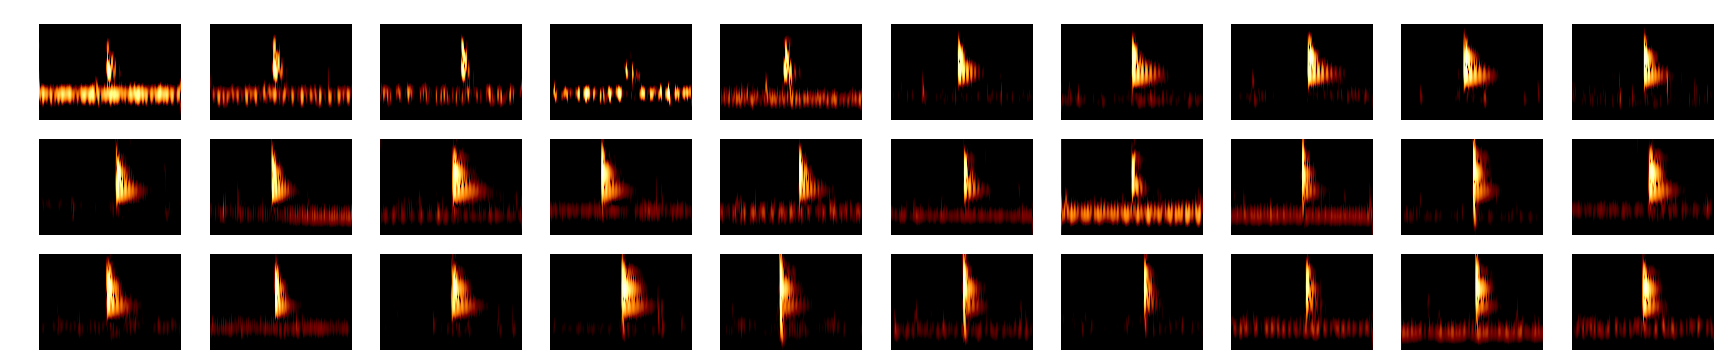

poor


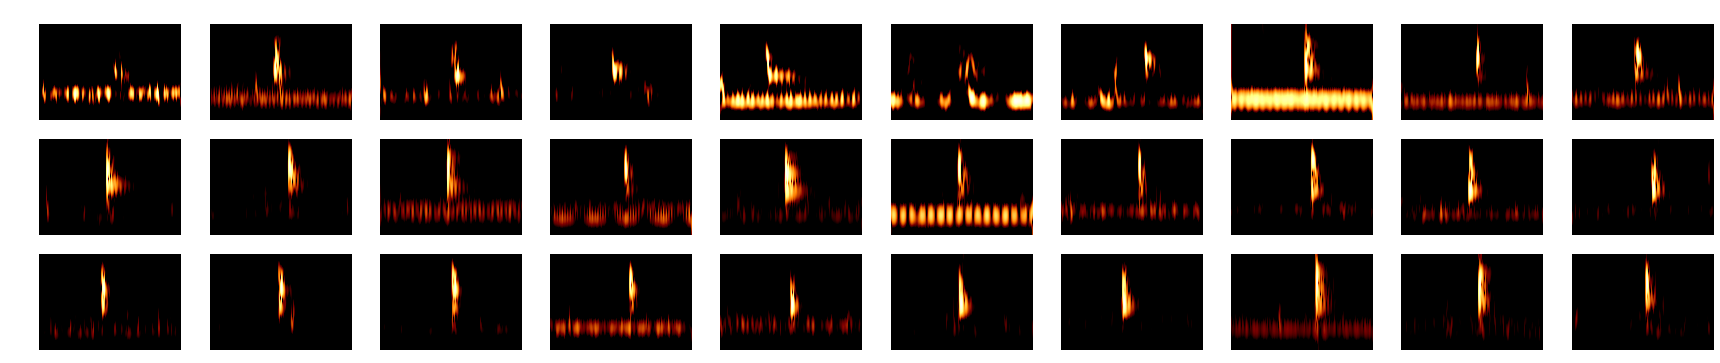

possible


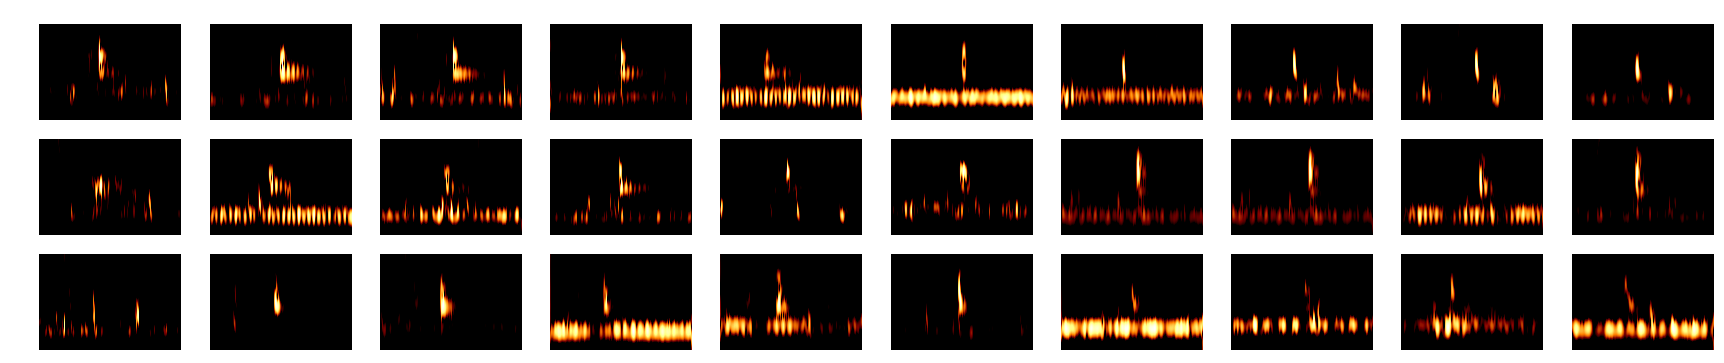

In [41]:
for click_value in clicks_df.click_value.unique():
    print(click_value)
    click_value_df = clicks_df[clicks_df.click_value == click_value]
    fig, axs = plt.subplots(nrows = nrow, ncols=ncol, figsize=(ncol*zoom_x, nrow*zoom_y))
    for axi in tqdm(range(nrow*ncol)):    

        click_row = click_value_df.iloc[axi]
        wav_row = wav_df[wav_df.stem == '_'.join(click_row.stem.split('.')[:-1])].iloc[0]
        wav_loc = wav_row.path

        rate = wav_row.rate
        data, rate = librosa.core.load(
            path=wav_loc,
            sr=None,
            offset=click_row["% start time"],
            duration=click_row[" end time"] - click_row["% start time"],
            mono=False
        )
        data = np.transpose(data)

        #audio = int16_to_float32(data)
        audio = butter_bandpass_filter(data, lowcut = 500, highcut=int(rate/2)-2, fs=rate, order=4)
        spectrogram = sg.spectrogram(audio, hparams)
        #mel_spec = np.dot(spectrogram.T, mel_matrix).T
        ax = axs.flatten()[axi] 
        ax.matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
        ax.axis('off')
    plt.show()